In [16]:
from incremental_explainer.utils.video import create_video, save_video
import matplotlib.pyplot as plt
from incremental_explainer.tracking import track_saliency_maps
def track_saliency_maps_with_video(frame_number, car_set_object, box_index):

    print(f"Frame number: {frame_number}, Car number: {car_set_object}, Explanation index: {box_index}")

    frames, auc_results, aux_results_2 = track_saliency_maps(frame_number=frame_number, car_number=car_set_object, box_index_first_frame=box_index)
    
    plt.boxplot(auc_results)
    mean_value = sum(auc_results) / len(auc_results)
    plt.title(f"Incremental results - Average: {mean_value}")
    plt.show()
    mean_value = sum(aux_results_2) / len(aux_results_2)
    plt.boxplot(aux_results_2)
    plt.title(f"Plain DRise results - Average: {mean_value}")
    plt.show()
    print(f"Number of frames: {len(frames)}")
    if len(frames) > 0:
        display(create_video(frames))
        save_video(frames, frame_number, car_set_object, box_index)

Frame number: 1468, Car number: 10, Explanation index: 1


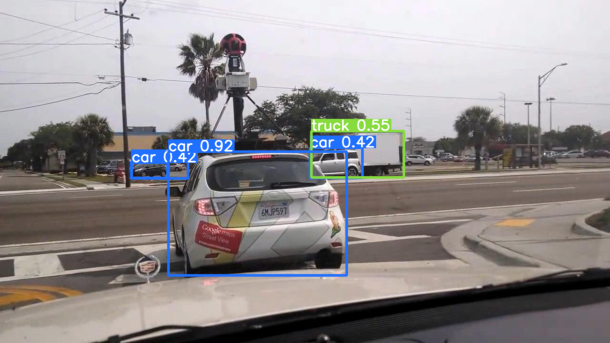

x: 653, y: 276, x2: 847, y2: 373
Class: truck, Confidence: 0.56


 53%|█████▎    | 53/100 [00:04<00:04, 11.53it/s]

In [17]:
track_saliency_maps_with_video(1468, 10, 1)

# for j in range(1, 100):
#     frame_number = random.randint(1, 1500)
#     car_number = random.randint(11, 20)
#     while car_number == 7 or car_number == 5 or car_number == 4:
#         car_number = random.randint(1, 10)
#     box_index = random.randint(0, 3)
#     track_saliency_maps_with_video(frame_number, car_number, box_index)